5 Epoch GAN Test

In [201]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import os
import logging
SEED = 0
keras.utils.set_random_seed(124)

In [202]:
csv_entry_data = pd.read_csv("onlinefraud.csv",sep=",")
credit_card_data=csv_entry_data
target_1_rows = credit_card_data[credit_card_data['isFraud'] == 1].head(20000)
target_0_rows = credit_card_data[credit_card_data['isFraud'] == 0].head(20000)
credit_card_data=pd.concat([target_1_rows, target_0_rows])
credit_card_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
20076,8,CASH_IN,141811.33,C1507170630,2596606.93,2738418.25,C746359178,742685.98,1793011.10,0,0
20077,8,CASH_IN,632085.47,C1414128792,2738418.25,3370503.73,C264685626,1736548.55,0.00,0,0
20078,8,CASH_IN,150605.27,C1540927,3370503.73,3521109.00,C75629578,1075492.86,707849.71,0,0
20079,8,CASH_IN,53634.28,C1781243086,3521109.00,3574743.28,C464246030,352529.81,0.00,0,0


Preprocessing

In [203]:
#Preprocess
def standardize_and_normalization(func_df,colname):
    denom=(func_df[colname].std())
    numer=(func_df[colname]-func_df[colname].mean())
    func_df[colname] =numer/denom
Dummy_Results = pd.get_dummies(credit_card_data["type"],prefix='Type_')
credit_card_data.drop("type", inplace=True, axis=1)
credit_card_data=pd.concat([credit_card_data,Dummy_Results],axis='columns')
credit_card_data = credit_card_data.drop("isFlaggedFraud", axis=1)
credit_card_data = credit_card_data.drop("nameOrig", axis=1)
credit_card_data = credit_card_data.drop("nameDest", axis=1)
#one hot encode the actions
credit_card_data['Type__CASH_IN'] = credit_card_data['Type__CASH_IN'].replace({True: 1, False: 0})
credit_card_data['Type__CASH_OUT'] = credit_card_data['Type__CASH_OUT'].replace({True: 1, False: 0})
credit_card_data['Type__DEBIT'] = credit_card_data['Type__DEBIT'].replace({True: 1, False: 0})
credit_card_data['Type__PAYMENT'] = credit_card_data['Type__PAYMENT'].replace({True: 1, False: 0})
credit_card_data['Type__TRANSFER'] = credit_card_data['Type__TRANSFER'].replace({True: 1, False: 0})
#standardize/normalize the numerical data
standardize_and_normalization(credit_card_data,'amount')
standardize_and_normalization(credit_card_data,'oldbalanceOrg')
standardize_and_normalization(credit_card_data,'newbalanceOrig')
standardize_and_normalization(credit_card_data,'oldbalanceDest')
standardize_and_normalization(credit_card_data,'newbalanceDest')
credit_card_data=credit_card_data.fillna(value=0)
credit_card_data

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Type__CASH_IN,Type__CASH_OUT,Type__DEBIT,Type__PAYMENT,Type__TRANSFER
2,1,-0.354846,-0.391393,-0.294012,-0.267946,-0.356414,1,0,0,0,0,1
3,1,-0.354846,-0.391393,-0.294012,-0.260288,-0.356414,1,0,1,0,0,0
251,1,-0.353038,-0.390421,-0.294012,-0.267946,-0.356414,1,0,0,0,0,1
252,1,-0.353038,-0.390421,-0.294012,-0.258473,-0.356414,1,0,1,0,0,0
680,1,-0.341108,-0.384007,-0.294012,-0.267946,-0.356414,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20076,8,-0.257298,0.569947,0.950778,0.000553,0.172395,0,1,0,0,0,0
20077,8,0.080382,0.622453,1.238102,0.359858,-0.356414,0,1,0,0,0,0
20078,8,-0.251241,0.856486,1.306561,0.120871,-0.147650,0,1,0,0,0,0
20079,8,-0.318030,0.912248,1.330942,-0.140498,-0.356414,0,1,0,0,0,0


In [204]:
def title_strip(data):
    dataframe_post_strip = pd.DataFrame(data)
    for c in range(dataframe_post_strip.shape[1]):
        mapping = {dataframe_post_strip.columns[c]: c}
        dataframe_post_strip = dataframe_post_strip.rename(columns=mapping)
    return dataframe_post_strip
entry_data_for_gan=credit_card_data.drop(columns=["isFraud"])
prepped_data = (entry_data_for_gan).values
X=prepped_data
y = (credit_card_data["isFraud"]).values
y_holder1=y
target_label1=y
X = KNNImputer().fit_transform(X)
credit_card_data = title_strip(StandardScaler().fit_transform(X))
credit_card_data
data_og=credit_card_data
data_og

,0,1,2,3,4,5,6,7,8,9,10
0,-0.547045,-0.354853,-0.391400,-0.294017,-0.267950,-0.356420,-0.380677,-0.614044,-0.126158,-0.7666,1.917608
1,-0.547045,-0.354853,-0.391400,-0.294017,-0.260292,-0.356420,-0.380677,1.628548,-0.126158,-0.7666,-0.521483
2,-0.547045,-0.353045,-0.390428,-0.294017,-0.267950,-0.356420,-0.380677,-0.614044,-0.126158,-0.7666,1.917608
3,-0.547045,-0.353045,-0.390428,-0.294017,-0.258477,-0.356420,-0.380677,1.628548,-0.126158,-0.7666,-0.521483
4,-0.547045,-0.341114,-0.384014,-0.294017,-0.267950,-0.356420,-0.380677,-0.614044,-0.126158,-0.7666,1.917608
...,...,...,...,...,...,...,...,...,...,...,...
28208,-0.512370,-0.257302,0.569957,0.950794,0.000553,0.172398,2.626897,-0.614044,-0.126158,-0.7666,-0.521483
28209,-0.512370,0.080383,0.622464,1.238124,0.359865,-0.356420,2.626897,-0.614044,-0.126158,-0.7666,-0.521483
28210,-0.512370,-0.251245,0.856501,1.306585,0.120873,-0.147652,2.626897,-0.614044,-0.126158,-0.7666,-0.521483
28211,-0.512370,-0.318036,0.912264,1.330965,-0.140500,-0.356420,2.626897,-0.614044,-0.126158,-0.7666,-0.521483


GAN 5 Epochs for synethtic data

In [205]:
class Gan_Class():
    def __init__(self, data):
        self.data = data
        #change this number to change the number of epochs
        self.epoch_number = 5
    def train(self, generator, discriminator, gan):
        for epoch in range(self.epoch_number):
            generated_data = generator.predict(self.noise_input())
            labels = np.concatenate([np.ones(self.data.shape[0]), np.zeros(self.data.shape[0])])
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)
            noise = self.noise_input()
            g_loss = gan.train_on_batch(noise, np.ones(self.data.shape[0]))
            print('>%d, d1=%.3f, d2=%.3f' %(epoch+1, d_loss, g_loss))
        return generator    
    def GAN_Generator(self):
        model = tf.keras.Sequential(name="generator")
        model.add(tf.keras.layers.Dense(60, activation='relu',kernel_initializer='he_uniform',input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(50, activation='gelu'))
        model.add(tf.keras.layers.Dense(128, activation='gelu'))
        model.add(tf.keras.layers.Dense(self.data.shape[1], activation='linear'))
        return model
    def noise_input(self):
        noise = np.random.normal(0, 1, self.data.shape)
        return noise
    def GAN_Discriminator(self):
        model = tf.keras.Sequential(name="discriminator")
        model.add(tf.keras.layers.Dense(8, activation='gelu', kernel_initializer='he_uniform',input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(16, activation='gelu'))
        model.add(tf.keras.layers.Dense(32, activation='gelu'))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='kld', optimizer='adam',metrics=['accuracy'])
        return model
    def GAN_Itself(self, generator, discriminator):
        generator.trainable = True
        discriminator.trainable = False
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='kld', optimizer='adam')
        return model
gan_train_data=credit_card_data[credit_card_data.index % 2 == 0]
model = Gan_Class(data=gan_train_data)
gen_V2 = model.GAN_Generator()
discy_V2 = model.GAN_Discriminator()
gan_model = model.GAN_Itself(generator=gen_V2, discriminator=discy_V2)
print(gan_model)
trained_model = model.train(generator=gen_V2, discriminator=discy_V2, gan=gan_model)
noise = np.random.normal(0, 1, gan_train_data.shape)
new_data = title_strip(data=trained_model.predict(noise))

c:\Programming\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=GAN, built=False>
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
>1, d1=0.403, d2=0.677
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
>2, d1=0.398, d2=0.663
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
>3, d1=0.394, d2=0.651
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
>4, d1=0.390, d2=0.639
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
>5, d1=0.386, d2=0.627
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


In [206]:
new_data

,0,1,2,3,4,5,6,7,8,9,10
0,-0.768440,0.570625,0.270354,-0.580258,-0.148348,-0.292884,0.136499,0.311810,-0.256102,-0.504142,-0.272741
1,-0.864071,0.347685,0.278323,-0.729668,0.333644,-0.431737,0.098654,-0.134384,-0.319603,-0.229458,-0.053698
2,-0.322375,0.728391,0.563168,-0.622401,-0.444923,-0.160908,0.455282,0.096901,-0.751020,-0.475954,0.307693
3,-0.422305,0.189274,0.227329,-0.693150,0.321046,-0.489291,0.104061,-0.110583,0.287710,-0.372219,-0.640169
4,-0.215661,0.318067,-0.012817,-0.036999,0.094167,0.021779,-0.028497,-0.122908,-0.126276,-0.240267,-0.131852
...,...,...,...,...,...,...,...,...,...,...,...
14102,-0.377957,0.670678,0.069658,-0.322077,-0.006212,-0.221532,0.040301,-0.102166,-0.500804,-0.390157,0.205479
14103,-1.324049,1.285943,-0.077144,-0.798639,-0.206675,-0.705918,-0.017959,-0.292026,-0.407243,-0.984958,0.121214
14104,-0.442310,0.721837,0.029419,-0.726031,-0.209848,-0.195486,0.283031,0.224452,-0.253103,-0.650348,-0.270323
14105,-1.009141,1.051082,0.121156,-0.754515,-0.212596,-0.726166,-0.017915,-0.242385,-0.180392,-0.791171,0.145064


Correlation Exploration

[[0.37454012 0.95071431 0.73199394 ... 0.60111501 0.70807258 0.02058449]
 [0.96990985 0.83244264 0.21233911 ... 0.29122914 0.61185289 0.13949386]
 [0.29214465 0.36636184 0.45606998 ... 0.60754485 0.17052412 0.06505159]
 ...
 [0.11047411 0.35462216 0.28723899 ... 0.42777313 0.38432665 0.67964728]
 [0.21825389 0.94996118 0.78634501 ... 0.61341139 0.16703395 0.99116863]
 [0.2316717  0.94273177 0.64964665 ... 0.18643826 0.77958447 0.35012526]]


Text(0.5, 1.0, 'Fraud Rand Data 5 epoch')

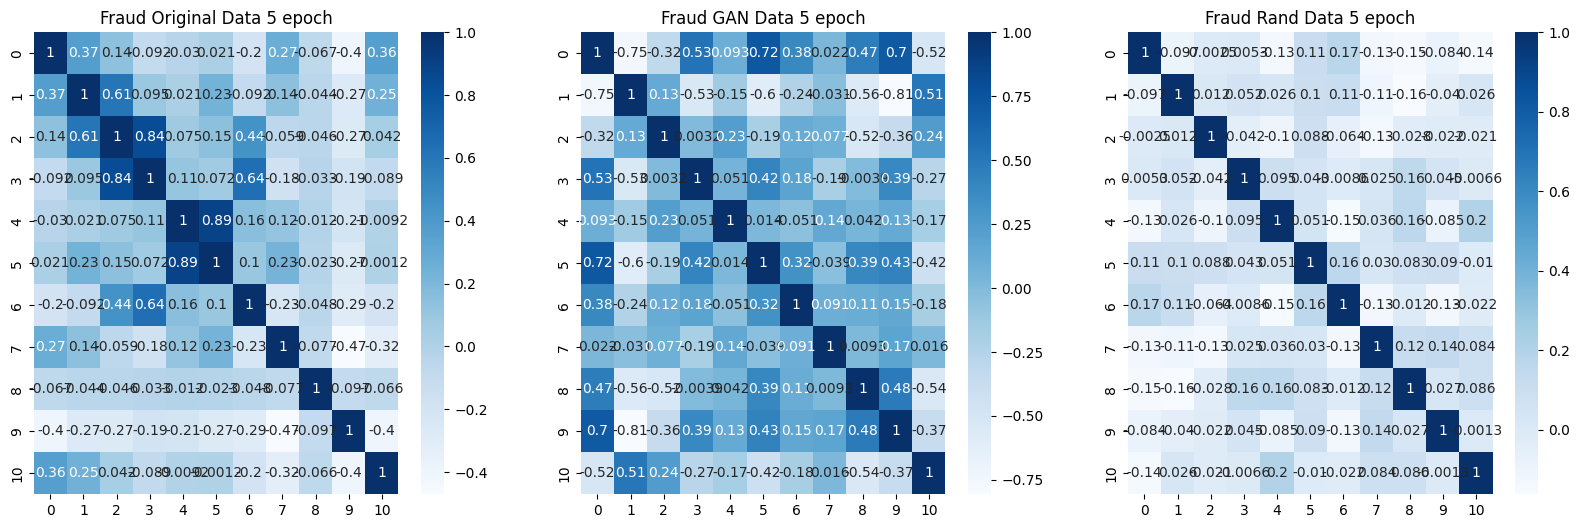

In [207]:
np.random.seed(42)
# Create a random 13-column array with 100 rows
random_array = np.random.rand(100, 11)
random_array_df=pd.DataFrame(random_array)
# Print the array
print(random_array)
# Dimension of the covariance matrix
n = 10
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
sns.heatmap(credit_card_data.corr(), annot=True, ax=ax[0], cmap="Blues")
sns.heatmap(new_data.corr(), annot=True, ax=ax[1], cmap="Blues")
sns.heatmap(random_array_df.corr(), annot=True, ax=ax[2], cmap="Blues")
ax[0].set_title("Fraud Original Data 5 epoch")
ax[1].set_title("Fraud GAN Data 5 epoch")
ax[2].set_title("Fraud Rand Data 5 epoch")

Fake Data Target Prepraration 

In [208]:
target_gan_data=y
target_gan_data_df=pd.DataFrame(target_gan_data)
target_gan_data_df

,0
0,1
1,1
2,1
3,1
4,1
...,...
28208,0
28209,0
28210,0
28211,0


1 in 8 fake are ID'd for training

Switch to change ratio of identified fake data

In [209]:
#comment out the target_gan_data_df['1'] variable changer you do not wish to happen and uncomment the other. i % 2 is the amount out of each entry you would like to be identified
target_gan_data_df['1']=[1 if i % 2 == 0 else 0 for i in range(len(target_gan_data_df[0]))]
#target_gan_data_df['1']=0
print(target_gan_data_df)
target_gan_data_df['1']


       0  1
0      1  1
1      1  0
2      1  1
3      1  0
4      1  1
...   .. ..
28208  0  1
28209  0  0
28210  0  1
28211  0  0
28212  0  1

[28213 rows x 2 columns]


0        1
1        0
2        1
3        0
4        1
        ..
28208    1
28209    0
28210    1
28211    0
28212    1
Name: 1, Length: 28213, dtype: int64

In [210]:
target_pre_gan_data=target_gan_data_df[0].values
print(target_pre_gan_data)
target_post_gan_data=target_gan_data_df['1'].values
print(target_post_gan_data)
X = (credit_card_data).values
y_holder=(csv_entry_data["isFraud"]).values
new_data_df=pd.DataFrame(new_data)
#strip data and get only the values
new_entry_data_for_gan=pd.DataFrame(entry_data_for_gan[:].values)
print(new_entry_data_for_gan)
#get the combined set of target and data itself
result_df = pd.concat([new_entry_data_for_gan, new_data], ignore_index=True)
print(result_df)
target_result_df = pd.concat([target_gan_data_df[0], target_gan_data_df['1']], ignore_index=True)
print(target_result_df)

[1 1 1 ... 0 0 0]
[1 0 1 ... 1 0 1]
        0         1         2         3         4         5    6    7    8   \
0      1.0 -0.354846 -0.391393 -0.294012 -0.267946 -0.356414  0.0  0.0  0.0   
1      1.0 -0.354846 -0.391393 -0.294012 -0.260288 -0.356414  0.0  1.0  0.0   
2      1.0 -0.353038 -0.390421 -0.294012 -0.267946 -0.356414  0.0  0.0  0.0   
3      1.0 -0.353038 -0.390421 -0.294012 -0.258473 -0.356414  0.0  1.0  0.0   
4      1.0 -0.341108 -0.384007 -0.294012 -0.267946 -0.356414  0.0  0.0  0.0   
...    ...       ...       ...       ...       ...       ...  ...  ...  ...   
28208  8.0 -0.257298  0.569947  0.950778  0.000553  0.172395  1.0  0.0  0.0   
28209  8.0  0.080382  0.622453  1.238102  0.359858 -0.356414  1.0  0.0  0.0   
28210  8.0 -0.251241  0.856486  1.306561  0.120871 -0.147650  1.0  0.0  0.0   
28211  8.0 -0.318030  0.912248  1.330942 -0.140498 -0.356414  1.0  0.0  0.0   
28212  8.0 -0.328881  0.932106  1.348160  0.133721  0.212849  1.0  0.0  0.0   

        9    10

In [211]:
new_entry_data_for_gan=pd.DataFrame(entry_data_for_gan[:].values)
print(new_entry_data_for_gan)
result_df = pd.concat([new_entry_data_for_gan, new_data], ignore_index=True)
print(result_df)
target_result_df = pd.concat([target_gan_data_df[0], target_gan_data_df['1']], ignore_index=True)
print(target_result_df)
result_df = pd.concat([new_entry_data_for_gan, new_data], ignore_index=True)
print(result_df)
target_result_df = pd.concat([target_gan_data_df[0], target_gan_data_df['1']], ignore_index=True)
print(target_result_df)

        0         1         2         3         4         5    6    7    8   \
0      1.0 -0.354846 -0.391393 -0.294012 -0.267946 -0.356414  0.0  0.0  0.0   
1      1.0 -0.354846 -0.391393 -0.294012 -0.260288 -0.356414  0.0  1.0  0.0   
2      1.0 -0.353038 -0.390421 -0.294012 -0.267946 -0.356414  0.0  0.0  0.0   
3      1.0 -0.353038 -0.390421 -0.294012 -0.258473 -0.356414  0.0  1.0  0.0   
4      1.0 -0.341108 -0.384007 -0.294012 -0.267946 -0.356414  0.0  0.0  0.0   
...    ...       ...       ...       ...       ...       ...  ...  ...  ...   
28208  8.0 -0.257298  0.569947  0.950778  0.000553  0.172395  1.0  0.0  0.0   
28209  8.0  0.080382  0.622453  1.238102  0.359858 -0.356414  1.0  0.0  0.0   
28210  8.0 -0.251241  0.856486  1.306561  0.120871 -0.147650  1.0  0.0  0.0   
28211  8.0 -0.318030  0.912248  1.330942 -0.140498 -0.356414  1.0  0.0  0.0   
28212  8.0 -0.328881  0.932106  1.348160  0.133721  0.212849  1.0  0.0  0.0   

        9    10  
0      0.0  1.0  
1      0.0  0.0

Evaluation

In [212]:
print(f"5 epoch run \n")
keras.utils.set_random_seed(120)
X_train, X_test, y_train, y_test = train_test_split(new_entry_data_for_gan, y, test_size=0.5, random_state=0,shuffle='true')
gnb_og = GaussianNB()
y_pred = gnb_og.fit(X_train, y_train).predict(X_test)
print(f"Number of mislabeled points out of a total points original dataset:", (X_test.shape[0], (y_test != y_pred).sum()),"error percentage ",((y_test != y_pred).sum())/X_test.shape[0])
X_train, X_test, y_train, y_test = train_test_split(new_data, y[::2], test_size=0.5, random_state=0,shuffle='true')
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(f"Number of mislabeled points out of a total points synethtic data :", (X_test.shape[0], (y_test != y_pred).sum()),"error percentage ",((y_test != y_pred).sum())/X_test.shape[0])
X_train, X_test, y_train, y_test = train_test_split(result_df,target_result_df[0:len(result_df)] , test_size=0.5, random_state=0, shuffle='true')
gnb_gan = GaussianNB()
y_pred = gnb_gan.fit(X_train, y_train).predict(X_test)
rep_value=(len(data_og))
y_test[y_test.index > rep_value]=1
print(f"Number of mislabeled points out of a total points combined dataset:", (X_test.shape[0], (y_test != y_pred).sum()), "error percentage ",((y_test != y_pred).sum())/X_test.shape[0])

5 epoch run 

Number of mislabeled points out of a total points original dataset: (14107, 2617) error percentage  0.18551073934925924
Number of mislabeled points out of a total points synethtic data : (7054, 2059) error percentage  0.291891125602495
Number of mislabeled points out of a total points combined dataset: (21160, 6279) error percentage  0.2967391304347826


In [213]:
print("DL model based on the original data")
X_train, X_test, y_train, y_test = train_test_split(entry_data_for_gan, y, test_size=0.5, random_state=0)
dl_og_model =tf.keras.Sequential([
    layers.Dense(32, activation='linear', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
dl_og_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
dl_og_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
test_loss, test_accuracy = dl_og_model.evaluate(X_test, y_test)
print(f'Epoch Loss Original Data: {test_loss}, Accuracy of Epoch Original Data: {test_accuracy}')


DL model based on the original data
Epoch 1/5


c:\Programming\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7534 - loss: 0.5299 - val_accuracy: 0.9964 - val_loss: 0.4276
Epoch 2/5
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9956 - loss: 0.4145 - val_accuracy: 0.9961 - val_loss: 0.3657
Epoch 3/5
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9953 - loss: 0.3552 - val_accuracy: 0.9961 - val_loss: 0.3142
Epoch 4/5
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9953 - loss: 0.3058 - val_accuracy: 0.9963 - val_loss: 0.2712
Epoch 5/5
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9953 - loss: 0.2645 - val_accuracy: 0.9960 - val_loss: 0.2355
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.9967 - loss: 0.2365
Epoch Loss Original Data: 0.23541317880153656, Accuracy of Epoch Original Data: 0.996030330657959


In [214]:
print("DL model based on the synthetic data 5 epoch run")
X_train, X_test, y_train, y_test = train_test_split(new_data, y[::2], test_size=0.5, random_state=0)
dl_gan_model = tf.keras.Sequential([
    layers.Dense(32, activation='linear', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
dl_gan_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
dl_gan_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
test_loss, test_accuracy = dl_gan_model.evaluate(X_test, y_test)
print(f'Epoch Loss Gan Data 5 Epoch: {test_loss}, Accuracy of Epoch Gan Data 5 Epoch: {test_accuracy}')


DL model based on the synthetic data 5 epoch run
Epoch 1/5


c:\Programming\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6617 - loss: 0.6476 - val_accuracy: 0.7143 - val_loss: 0.6051
Epoch 2/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6997 - loss: 0.6151 - val_accuracy: 0.7143 - val_loss: 0.6026
Epoch 3/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6997 - loss: 0.6132 - val_accuracy: 0.7143 - val_loss: 0.6015
Epoch 4/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6997 - loss: 0.6123 - val_accuracy: 0.7143 - val_loss: 0.6009
Epoch 5/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6997 - loss: 0.6118 - val_accuracy: 0.7143 - val_loss: 0.6003
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.7151 - loss: 0.6015
Epoch Loss Gan Data 5 Epoch: 0.600827157497406, Accuracy of Epoch Gan Data 5 Epoch: 0.7143464684486389


In [215]:
print("DL model based on the original data 5 epoch run")

X_train, X_test, y_train, y_test = train_test_split(result_df, target_result_df[0:len(result_df)], test_size=0.3, random_state=0,shuffle=True)

rep_value=(len(data_og))
y_test[y_test.index > rep_value]=1
dl_com_gan_model = tf.keras.Sequential([
    layers.Dense(16, activation='linear', input_shape=(X_train.shape[1],)),
    layers.Dense(8, activation='gelu'),layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
dl_com_gan_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
dl_com_gan_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
test_loss, test_accuracy = dl_com_gan_model.evaluate(X_test, y_test)
print(f'Epoch Loss Combined Data 5 Epoch: {test_loss}, Accuracy of Epoch Combined Data 5 Epoch: {test_accuracy}')

DL model based on the original data 5 epoch run
Epoch 1/5


c:\Programming\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


463/463 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7662 - loss: 0.4353 - val_accuracy: 0.7389 - val_loss: 0.2830
Epoch 2/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.8310 - loss: 0.2578 - val_accuracy: 0.7570 - val_loss: 0.2624
Epoch 3/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.8314 - loss: 0.2484 - val_accuracy: 0.7600 - val_loss: 0.2537
Epoch 4/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8303 - loss: 0.2462 - val_accuracy: 0.7546 - val_loss: 0.2513
Epoch 5/5
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.8306 - loss: 0.2450 - val_accuracy: 0.7380 - val_loss: 0.2506
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.7424 - loss: 0.2466
Epoch Loss Combined Data 5 Epoch: 0.2506496012210846, Accuracy of Epoch Combined Data 5 Epoch: 0.7380277514457703
